# Sequential Monte Carlo on a Non-Markovian Gaussian State-Space model

We consider a non-Markovian Gaussian sequence model (NM-GSM) of the form
$$
\begin{aligned}
    f_t(x_t \vert x_{t-1}) &= \mathcal{N}(x_t \vert \phi x_{t-1}, q),\\
    g_t(y_t \vert x_{1:t}) &= \mathcal{N}(y_t \vert \phi x_{t-1}, r)
\end{aligned}
$$

The complete likelihood is given by
$$
\begin{aligned}
    p({\bf x}, {\bf y}) &= p(x_1) p(y_1 | x_1) \prod_{t=2}^T p(x_t \vert x_{1:t-1}) p(y_t \vert x_t)\\
    &= \mathcal{N}(x_1 \vert 0, 1) \mathcal{N}(y_1, x_1, r)\prod_{t=2}^T \mathcal{N}(x_t \vert \phi x_{t-1}, q) \mathcal{N}(x_t \vert \phi x_{t-1}, q)
\end{aligned}
$$

In [ ]:
import os

In [ ]:
os.chdir("../")

In [ ]:
import jax
import einops
import distrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jsmc.datagen import non_markovian_gsm as nmgsm
from jsmc.samplers import sequential_monte_carlo as smc

In [4]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

## Sampling NM-GSM

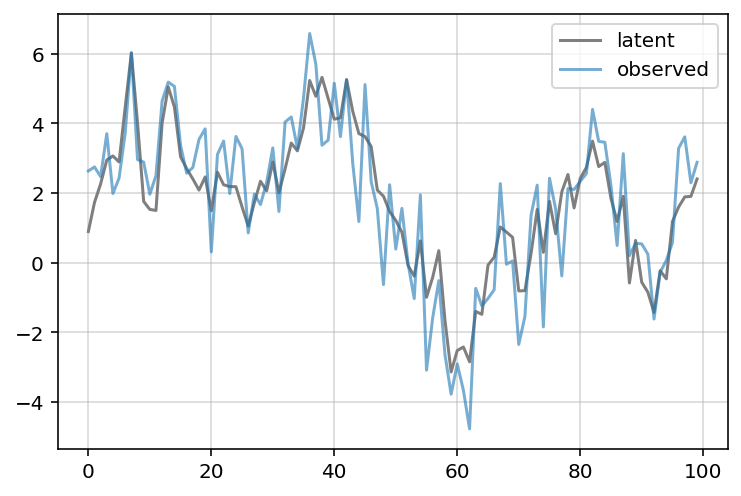

In [5]:
key = jax.random.PRNGKey(314)
key_sample, key_filter = jax.random.split(key, 2)

num_steps = 100
params = nmgsm.ModelParameters(phi=1.0, q=1.0, beta=0.05, r=1.0)
simulation = nmgsm.simulate(key_sample, params, num_steps)

plt.plot(simulation.x, label="latent", c="tab:gray")
plt.plot(simulation.y, label="observed", c="tab:blue", alpha=0.6)
plt.legend()
plt.grid(alpha=0.5)

In [6]:
class BootstrapProposal:
    def __init__(self, params: nmgsm.ModelParameters):
        self.params = params
    
    def sample(self, key, particle_cond, step, _):
        phi = self.params.phi
        q = self.params.q
        last_sample = particle_cond[step]
        
        eps = jax.random.normal(key)
        new_sample = phi * last_sample + jnp.sqrt(q) * eps
        return new_sample
    
    def logpdf(self, x, particles, step):
        phi = self.params.phi
        q = self.params.q
        last_sample = particles[step]
        
        dist_norm = distrax.Normal(loc=last_sample * phi, scale=jnp.sqrt(q))
        return dist_norm.log_prob(x)
    
    
class Target:
    def __init__(self, params: nmgsm.ModelParameters):
        self.params = params
    
    def logpdf(self, particles, step, obs):
        num_obs = len(obs)
        particles = particles.squeeze()
        indv = jnp.arange(num_obs) <= step
        log_likelihood = nmgsm.log_joint(particles, obs, self.params)
        log_likelihood = jnp.einsum("n,n->", log_likelihood, indv)
        return log_likelihood

In [7]:
num_particles = 150
dim_particle = 1

proposal = BootstrapProposal(params)
target = Target(params)


state_init = smc.init_state(num_particles, num_steps, dim_particle)

# Initialise particles
particles_init = jax.random.normal(key_filter, (num_particles,)) * jnp.sqrt(params.q)
particles = state_init.particles.at[:, 0, 0].set(particles_init)
state_init = state_init.replace(particles=particles)

# Initialise weights
logt1 = jax.vmap(target.logpdf, (0, None, None))(state_init.particles, 1, simulation.y)
logp1 = distrax.Normal(loc=0, scale=jnp.sqrt(params.q)).log_prob(particles_init)
logw_init = logt1 - logp1
state_init = state_init.replace(log_weights=logw_init, step=0)

/Users/myli/opt/anaconda3/envs/py39/lib/python3.9/site-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


In [8]:
keys_filter = jax.random.split(key_filter, num_steps)

def step(state, key):
    state, ix_resampled, particles = smc.step_and_update(key, state, simulation.y, proposal, target)
    output = {
        "log_weights": state.log_weights,
        "ix_resampled": ix_resampled,
        "particles": particles,
    }
    return state, output

In [9]:
state, output = jax.lax.scan(step, state_init, keys_filter)
logw_hist = output["log_weights"]
ix_resampled = output["ix_resampled"]

logw_hist = jnp.roll(logw_hist, 1, axis=0).at[0].set(state_init.log_weights)
particles = jnp.roll(state.particles, 1, axis=1).at[:, 0, :].set(state_init.particles[:, 0, :])

w_hist = jnp.exp(logw_hist - jax.nn.logsumexp(logw_hist, axis=-1, keepdims=True))

The normalisation constant can be estimated by

$$
    \hat Z_T = \prod_{t=1}^T\frac{1}{S}\sum_{s=1}^S \tilde{w}_t^{(s)}
$$

So that the log-normalisation constant, if we are given a set of log-weights can be estimated as

$$
    \log{\hat{Z}_T} = \sum_{t=1}^T\log\left(\frac{1}{S}\sum_{s=1}^S\exp\left( \log\tilde w_t^{(s)}\right)\right),
$$

which can be obtained by making use of the log-sum-exp trick.

In [10]:
particles = einops.rearrange(output["particles"], "timesteps particles dim -> particles (timesteps dim)")

mll_est = jax.nn.logsumexp(logw_hist, b=1/num_particles, axis=-1)
mll_true = nmgsm.log_observation(simulation.x, simulation.y, params)

print("Final MLL")
print(f"true: {sum(mll_true):0.4f}")
print(f"smc:  {sum(mll_est):0.4f}")

Final MLL
true: -145.7833
smc:  -198.7129


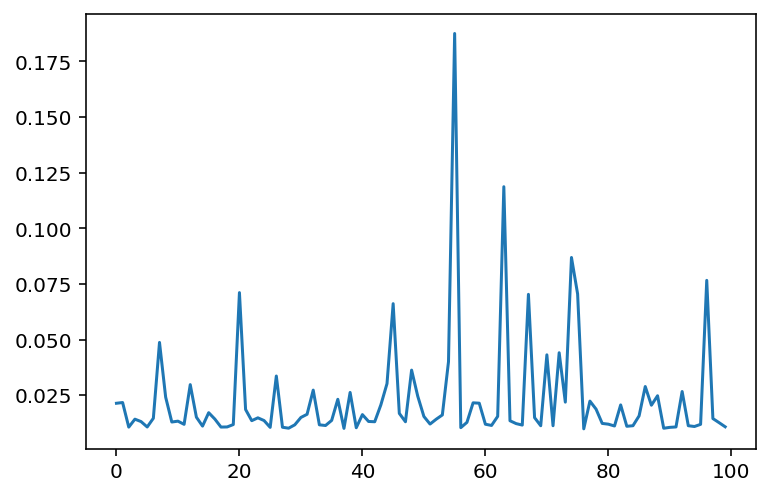

In [11]:
plt.plot(w_hist.max(axis=-1))

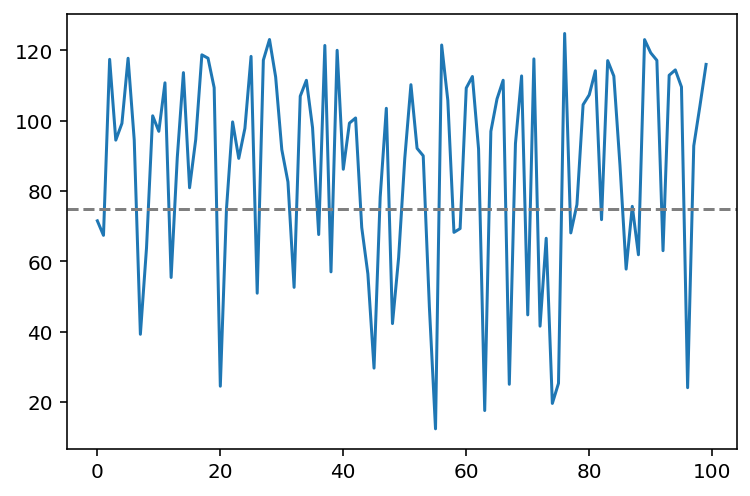

In [12]:
# Effective sample size
ess = 1 / jnp.power(w_hist, 2).sum(axis=-1)
plt.plot(ess)
plt.axhline(y=num_particles / 2, c="tab:gray", linestyle="--")

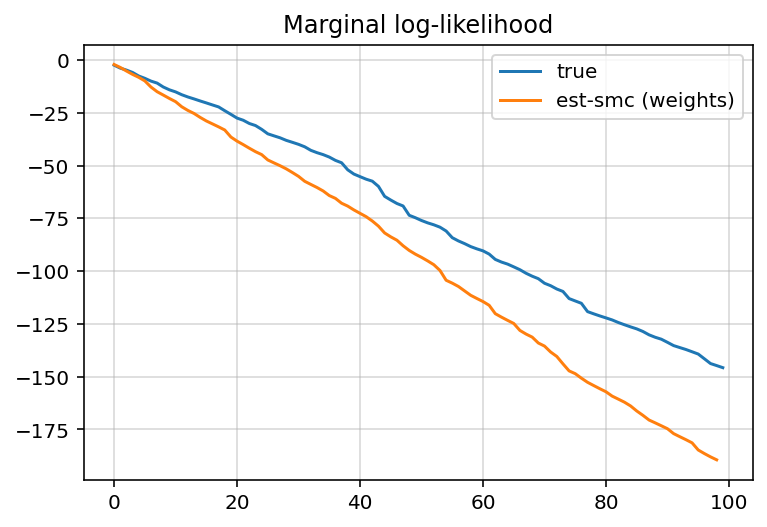

In [13]:
plt.plot(mll_true.cumsum(), label="true")
plt.plot(mll_est[1:].cumsum(), label="est-smc (weights)")
plt.legend()
plt.title("Marginal log-likelihood")
plt.grid(alpha=0.5)

## Comparing posterior mean with ground truth

In [14]:
xhat_filtered = jnp.einsum("ts,st->t", w_hist, particles)
xhat_uniform = particles.mean(axis=0)

Text(0.5, 1.0, 'Sampled particles')

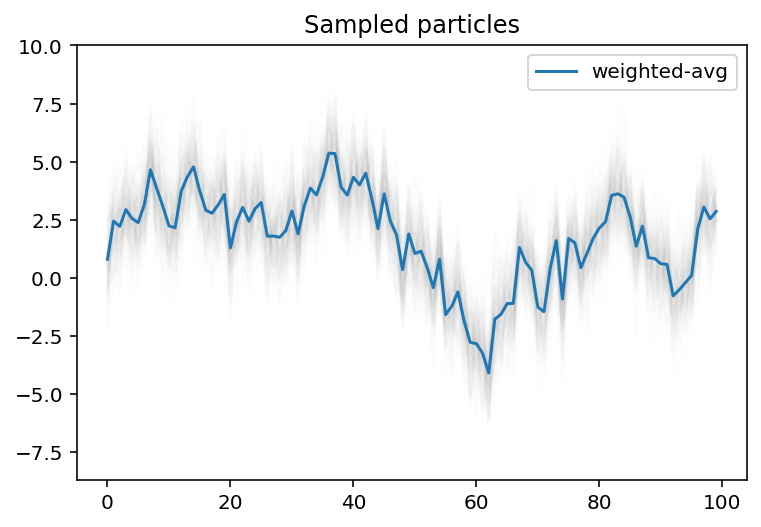

In [15]:
plt.plot(particles.T, c="tab:gray", alpha=0.005)
plt.plot(xhat_filtered, label="weighted-avg")
plt.legend()
plt.title("Sampled particles")

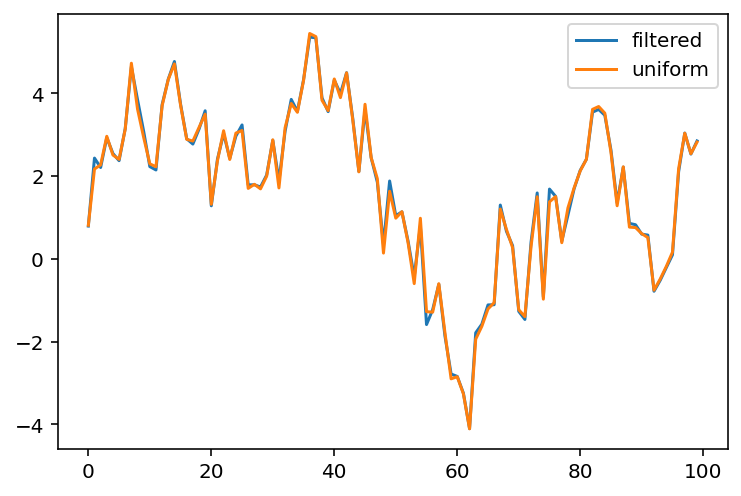

In [16]:
plt.plot(xhat_filtered, label="filtered")
plt.plot(jnp.roll(xhat_uniform, 0), label="uniform")st
plt.legend()

NameError: name 'xhat' is not defined

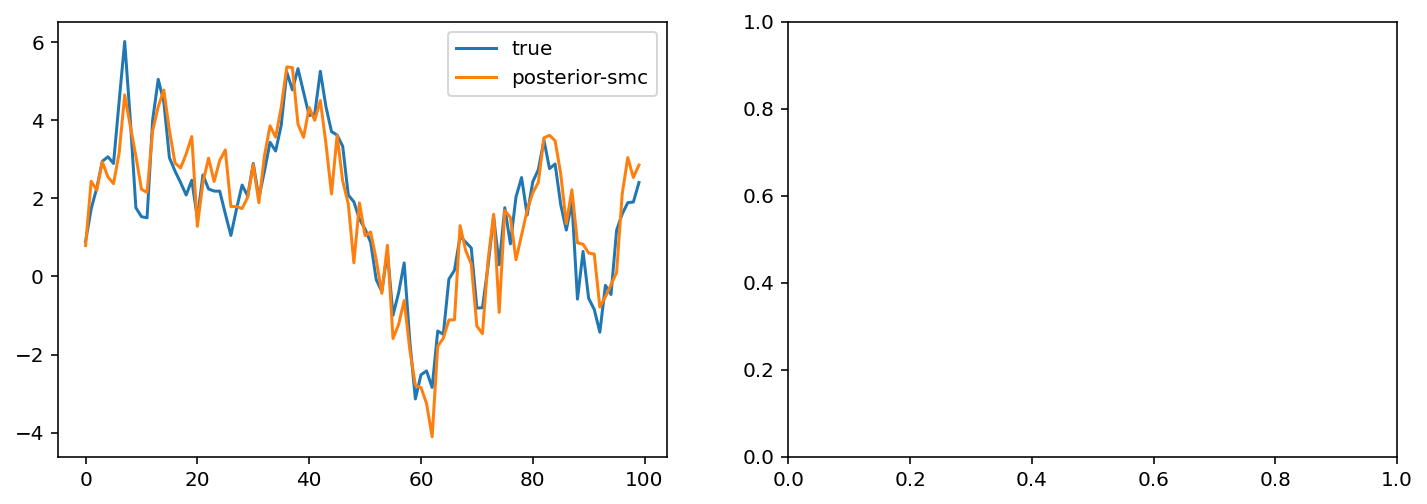

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(simulation.x, label="true")
ax[0].plot(xhat_filtered, label="posterior-smc")
ax[0].legend()

ax[1].scatter(simulation.x, xhat)
ax[1].set_xlabel("True latent")
ax[1].set_ylabel("Est latent")

plt.suptitle("Posterior estimation comparisson")

## Variance of the log- normalisation constant